In [3]:
%pip install "ragas>=0.1.7" "langchain>=0.2.0" "langchain-community>=0.2.0" "langchain-core>=0.2.0" "langchain-groq>=0.1.4" "langchain-huggingface>=0.0.3" "pypdf>=4.2.0" "faiss-cpu>=1.8.0" "beautifulsoup4>=4.12.3" "python-dotenv>=1.0.1" "ipywidgets>=8.1.3" "pandas>=2.2.2" "sentence-transformers"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\balak\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

import pandas as pd
from dotenv import load_dotenv
import bs4

# LangChain components
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# Ragas components
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall

# Load environment variables from .env file
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
if not GROQ_API_KEY:
    raise ValueError("GROQ_API_KEY not found in .env file")

print("✅ Environment variables loaded.")

USER_AGENT environment variable not set, consider setting it to identify your requests.


✅ Environment variables loaded.


In [5]:


# --- 1. Load Data ---
# Note: Use a file path that works in your environment
PDF_PATHS = [
    r"C:\Users\balak\medibot\A-Z Family Medical Encyclopedia.pdf",
    r"C:\Users\balak\medibot\The-Gale-Encyclopedia-of-Medicine-3rd-Edition-staibabussalamsula.ac_.id_.pdf"
]

pdf_docs = []
for path in PDF_PATHS:
    loader = PyPDFLoader(path)
    pdf_docs.extend(loader.load())

web_loader = WebBaseLoader(
    web_paths=["https://www.nhsinform.scot/illnesses-and-conditions/a-to-z/","https://www.drugs.com/drug_information.html"],
    bs_kwargs=dict(parse_only=bs4.SoupStrainer(["h1", "p", "li"]))
)
web_docs = web_loader.load()

documents = pdf_docs + web_docs
print(f"✅ Loaded {len(documents)} documents.")

# --- 2. Split Documents ---
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)
print(f"✅ Split documents into {len(chunks)} chunks.")

# --- 3. Create Vector Store ---
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
db = FAISS.from_documents(chunks, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})
print("✅ FAISS vector store and retriever created.")

✅ Loaded 5322 documents.
✅ Split documents into 28887 chunks.
✅ FAISS vector store and retriever created.


In [13]:
# --- 4. Define LLM and a Simplified Prompt ---
llm = ChatGroq(model="meta-llama/llama-4-maverick-17b-128e-instruct", api_key=GROQ_API_KEY,timeout=600)

prompt = ChatPromptTemplate.from_template("""
You are MedBot, an expert AI assistant specializing in summarizing medical information. 
    Your task is to answer user questions accurately and concisely based *exclusively* on the provided medical text.

    **Instructions:**
    1.  **Analyze the Context:** Carefully read the provided context to find information relevant to the user's question.
    2.  **Synthesize the Answer:** Combine the relevant information into a clear, easy-to-understand answer.
    3.  **Handle Missing Information:** If the answer cannot be found in the context, you *must* respond with: "I'm sorry, but I couldn't find information on that topic in my provided documents. For medical advice, please consult a qualified healthcare professional."
    4.  **Add a Disclaimer:** *Always* end your response with the following disclaimer on a new line:
        ---
        *Disclaimer: This information is for educational purposes only and is not a substitute for professional medical advice.*

Context:
{context}

Question:
{question}
""")

# --- Utility: Format retrieved docs for prompt ---
def format_docs(docs):
    """Format a list of Document objects into a single string for the prompt."""
    return "\n\n".join(doc.page_content for doc in docs)

# --- 5. Create the RAG Chain ---
# Your existing RAG chain definition below will now work correctly with this new prompt.
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print("✅ RAG chain  is ready.")

✅ RAG chain  is ready.


In [14]:
# --- Test the chain with a sample query ---
query = "What is the recommended first-aid for a minor burn?"

# Invoke the chain directly with the query string
response = rag_chain.invoke(query)
print("❓ Query:", query)
print("\n🤖 Response:", response)


❓ Query: What is the recommended first-aid for a minor burn?

🤖 Response: For a minor burn, the recommended first-aid is to leave it exposed to the air to promote healing. If the skin is broken or likely to be disturbed, apply an antibacterial ointment lightly and cover with a sterile bandage. Additionally, pain relief can be achieved by taking aspirin, acetaminophen (Tylenol), or ibuprofen (Advil). 
---
*Disclaimer: This information is for educational purposes only and is not a substitute for professional medical advice.*


In [16]:
# --- 6. Prepare Evaluation Dataset ---
# In a real project, this dataset would be larger and more carefully curated.
eval_questions = [
    # --- Category: Definitions & Functions ---
    "What is Acute respiratory distress syndrome (ARDS)?",
    "What causes Addison's disease?",
    "Describe the function of the thyroid gland.",
    "What is the function of the kidneys?",
    "What is cholesterol?",
    "What is chemotherapy?",

    # --- Category: Symptoms & Diagnosis ---
    "What are the main symptoms of an Abdominal aortic aneurysm?",
    "What are the common symptoms of a concussion?",
    "How is iron-deficiency anemia diagnosed?",
    "What is the purpose of a Pap test (smear)?",
    "What are the classic signs of a heart attack?",
    "How is hypothyroidism diagnosed?",
    
    # --- Category: Treatment & Management ---
    "Can you tell me about the treatment for Acne?",
    "How is hypertension (high blood pressure) typically managed?",

    # --- Category: First Aid & Prevention ---
    "What is the recommended first-aid for a minor burn?",
    "How can one reduce the risk of osteoporosis?",
    "What is the immediate first aid for a suspected sprain?",
    "What are the risk factors for developing Type 2 diabetes?",

    # --- Category: Comparative Questions ---
    "Explain what happens during an asthma attack.",
    "What are the differences between osteoarthritis and rheumatoid arthritis?",
    "What is the difference between a virus and a bacterium?",

   
]

# Ground truth answers correspond to each question above.
ground_truths = [
    # --- Definitions & Functions ---
    "ARDS is a life-threatening condition where the lungs cannot provide enough oxygen to vital organs.",
    "Addison's disease is a disorder where the adrenal glands don't produce enough hormones, often caused by an autoimmune response.",
    "The thyroid gland produces hormones that regulate the body's metabolism, energy levels, and body temperature.",
    "The kidneys filter waste from the blood, regulate blood pressure, and maintain electrolyte balance.",
    "Cholesterol is a waxy substance in the blood needed for cell building; high levels can lead to heart disease.",
    "Chemotherapy is a cancer treatment using drugs to kill fast-growing cancer cells.",

    # --- Symptoms & Diagnosis ---
    "The main symptom is a pulsating feeling in the abdomen, sometimes with persistent back or abdominal pain.",
    "Common concussion symptoms include headache, confusion, dizziness, nausea, and sensitivity to light.",
    "Iron-deficiency anemia is diagnosed via blood tests measuring hemoglobin and ferritin levels.",
    "A Pap test is a screening procedure for cervical cancer.",
    "Classic heart attack signs include chest pain, shortness of breath, and discomfort in the arms, back, or neck.",
    "Hypothyroidism is diagnosed with blood tests measuring TSH and thyroxine levels.",

    # --- Treatment & Management ---
    "Acne treatment varies and can include topical creams, oral antibiotics, or isotretinoin.",
    "Hypertension is managed with lifestyle changes (diet, exercise) and medications.",

    # --- First Aid & Prevention ---
    "First-aid for a minor burn involves cooling it with running water and covering it with a sterile bandage.",
    "Osteoporosis risk is reduced by adequate calcium/vitamin D, weight-bearing exercise, and avoiding smoking.",
    "Immediate first aid for a sprain is the RICE method: Rest, Ice, Compression, and Elevation.",
    "Risk factors for Type 2 diabetes include obesity, a sedentary lifestyle, family history, and high blood pressure.",

    # --- Comparative Questions ---
    "During an asthma attack, airways in the lungs narrow and become inflamed, making breathing difficult.",
    "Osteoarthritis is from mechanical wear and tear on joints; rheumatoid arthritis is an autoimmune disease attacking the joints.",
        "Bacteria are living single-celled organisms treatable with antibiotics; viruses are non-living agents that require a host cell and are not affected by antibiotics.",
    ]
    
  

# --- Generate answers and contexts using our RAG chain ---
answers = []
contexts = []

for question in eval_questions:
    response = rag_chain.invoke(question)
    answers.append(response)
    # Retrieve the context documents used for this answer
    retrieved_docs = retriever.invoke(question)
    contexts.append([doc.page_content for doc in retrieved_docs])

# --- Create a Hugging Face Dataset ---
eval_data = {
    "question": eval_questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truth": ground_truths,
}

eval_dataset = Dataset.from_dict(eval_data)
print("✅ Evaluation dataset created.")
eval_dataset

✅ Evaluation dataset created.


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 21
})

In [17]:
# --- 7. Run Ragas Evaluation ---
# Define the metrics we want to use
metrics = [
    faithfulness,       # How factually consistent is the answer with the context?
    answer_relevancy,   # How relevant is the answer to the question?
    context_precision,  # How relevant are the retrieved contexts to the question?
    context_recall,     # How well does the retrieved context cover the ground truth answer?
]

# Run the evaluation
print("⏳ Running Ragas evaluation...")
result = evaluate(
    dataset=eval_dataset,
    metrics=metrics,
    llm=llm,
    embeddings=embeddings,
    batch_size=1,
    raise_exceptions=False
)
print("✅ Evaluation complete.")

# --- 8. Display Results ---
df = result.to_pandas()
pd.set_option('display.max_colwidth', None) # Show full text in columns
df

⏳ Running Ragas evaluation...


Evaluating:   0%|          | 0/84 [00:00<?, ?it/s]

Batch 1/84:   0%|          | 0/1 [00:00<?, ?it/s]

Exception raised in Job[1]: BadRequestError(Error code: 400 - {'error': {'message': "'n' : number must be at most 1", 'type': 'invalid_request_error'}})
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[9]: BadRequestError(Error code: 400 - {'error': {'message': "'n' : number must be at most 1", 'type': 'invalid_request_error'}})
Exception raised in Job[13]: BadRequestError(Error code: 400 - {'error': {'message': "'n' : number must be at most 1", 'type': 'invalid_request_error'}})
Exception raised in Job[17]: BadRequestError(Error code: 400 - {'error': {'message': "'n' : number must be at most 1", 'type': 'invalid_request_error'}})
Exception raised in Job[21]: BadRequestError(Error code: 400 - {'error': {'message': "'n' : number must be at most 1", 'type': 'invalid_request_error'}})
Exception raised in Job[25]: BadRequestError(Error code: 400 - {'error': {'message': "'n' : number must be at most 1", 'type': 'invalid_request_error'}})
Exception raised in Job[29]: BadReq

✅ Evaluation complete.


,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_precision,context_recall
0,What is Acute respiratory distress syndrome (ARDS)?,"[Adult respiratory distress\nsyndrome\nDefinition\nAdult respiratory distress syndrome(ARDS), also\ncalled acute respiratory distress syndrome, is a type\nof lung (pulmonary) failure that may result from any\ndisease that causes large amounts of fluid to collect\nin the lungs. ARDS is not itself a specific disease, but a\nsyndrome, a group of symptoms and signs that\nmake up one of the most important forms of lung or\nrespiratory failure. It can develop quite suddenly in\npersons whose lungs have been perfectly normal.\nVery often ARDS is a true medical emergency. The\nbasic fault is a breakdown of the barrier, or mem-\nbrane, that normally keeps fluid from leaking out of\nthe small blood vessels of the lung into the breathing\nsacs (the alveoli).\nDescription\nAnother name for ARDS is shock lung. Its formal\nname is misleading, because children, as well as adults,\nmay be affected. In the lungs the smallest blood ves-\nsels, or capillaries, make contact with the alveoli, tiny, 659\narteries), brain damage,coma, and death.\nThe patient should be given rescue\nbreathing and, if necessary , placed on a\nventilator without delay . The cause of the\nrespiratory arrest will be treated.\nrespiratory distress syndrome\nAn acute lung disorder that makes\nbreathing difficult and leads to \nrespira-\ntory failure , resulting in life-threatening\nhypoxia (an inadequate supply of oxy-\ngen to the tissues). The condition may\nalso cause failure of other systems; for\nexample,\nheart failure or kidney failure.\nThere are two types of respiratory\ndistress syndrome. The first is seen in\npremature babies (see \nprematurity): the\nlungs are stiff and do not inflate easily\ndue to a lack of \nsurfactant, a group of\nchemicals that keep the alveoli (tiny air\nsacs in the lungs; see \nalveolus, pulmonary)\nopen. In adults, the condition is known\nas acute respiratory distress syndrome\n(ARDS) and may develop as a result of a\nsevere injury or overwhelming infection\n(particularly \nsepticaemia)., into the blood, must be treated promptly to avoid the\nlung injury that causes ARDS.\nResources\nBOOKS\nSmolley, Lawrence A., and Debra F. Bryse.Breathe\nRightNow: A Comprehensive Guide to Understanding\nand Treating the Most Common Breathing Disorders.\nNew York: W. W. Norton & Co., 1998.\nGALE ENCYCLOPEDIA OF MEDICINE 75\nAdult respiratory distress syndrome, Internal Medicine. New York: McGraw-Hill, 1997.\nORGANIZATIONS\nAmerican Kidney Fund (AKF). Suite 1010, 6110 Executive\nBoulevard, Rockville, MD 20852. (800) 638-8299.\n<http://216.248.130.102/Default.htm>.\nNational Kidney Foundation. 30 East 33rd St., New\nYork, NY 10016. (800) 622-9010.<http://\nwww.kidney.org>.\nMaureen Haggerty\nAcute respiratory distress syndrome see\nAdult respiratory distress syndrome\nAcute stress disorder\nDefinition\nAcute stress disorder (ASD) is ananxiety disorder\ncharacterized by a cluster of dissociative and anxiety\nsymptoms occurring within one month of a traumatic\nevent. (Dissociation is a psychological reaction to\ntrauma in which the mind tries to cope by ‘‘sealing\noff ’’ some features of the trauma from conscious\nawareness).\nDescription\nAcute stress disorder is a new diagnostic category\nthat was introduced in 1994 to differentiate time-lim-\nited reactions to trauma frompost-traumatic stress\ndisorder (PTSD).\nCauses and symptoms]","Acute respiratory distress syndrome (ARDS) is a type of lung failure that occurs when large amounts of fluid collect in the lungs, often as a result of a severe injury or overwhelming infection. It is also known as ""shock lung"" and can develop suddenly in individuals with previously normal lungs. ARDS is characterized by a breakdown of the barrier that keeps fluid from leaking out of the small blood vessels into the breathing sacs (alveoli), leading to respi

In [18]:
# Assume 'df' is your DataFrame with the Ragas results

# Save the DataFrame to a CSV file
file_name = "ragas_evaluation_results.csv"
df.to_csv(file_name, index=False)

print(f"✅ Evaluation table saved successfully as '{file_name}'")

✅ Evaluation table saved successfully as 'ragas_evaluation_results.csv'


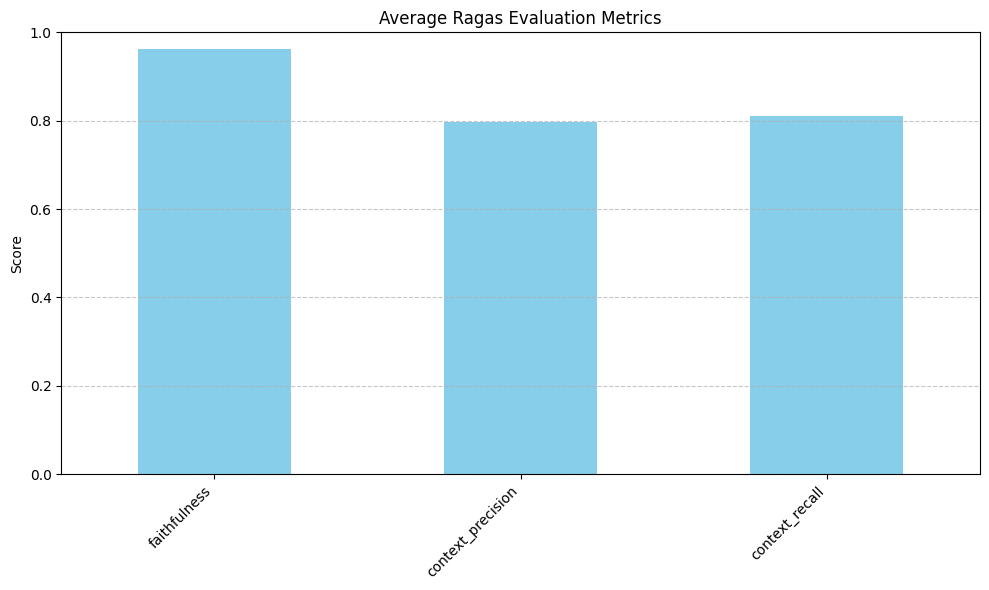

faithfulness: 0.9611341039912469
context_precision: 0.7962962962640652
context_recall: 0.8095238095238095


In [19]:
import matplotlib.pyplot as plt

# Calculate mean scores for each metric (excluding text columns)
metrics_to_plot = ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall']
mean_scores = df[metrics_to_plot].mean().dropna() # Add .dropna() to remove any NaN metrics from the plot if they still exist

# Plot as a bar chart
plt.figure(figsize=(10, 6)) # Add a figure size for better readability
mean_scores.plot(kind='bar', color='skyblue')
plt.title('Average Ragas Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right') # Rotate and align labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"faithfulness: {mean_scores.get('faithfulness', 'N/A')}")
print(f"context_precision: {mean_scores.get('context_precision', 'N/A')}")
print(f"context_recall: {mean_scores.get('context_recall', 'N/A')}")

In [23]:
# --- Test the chain with a sample query ---
query = "where is ap located"

response = rag_chain.invoke(query)
print("❓ Query:", query)
print("\n🤖 Response:", response)

❓ Query: where is ap located

🤖 Response: The context doesn't directly mention "ap" being a location, but it does mention "AP" in the context of "APOE" (apolipoprotein E), which is a gene on chromosome 19. However, I believe you are referring to "AP" as in "AP" ( likely referring to a medical condition). The text mentions "AP" as a condition that is diagnosed based on symptoms, medical history, and blood and urine tests. The condition "AP" is likely referring to a condition that affects various parts of the body, including the joints, abdomen, kidneys, and other organs.

To provide a more accurate answer, I will look for a condition that is abbreviated as "AP". The text mentions "AP" in the context of "APOE", but it also mentions a condition that is diagnosed and treated. The condition is likely "Henoch-Schönlein purpura" or another condition that is not explicitly named.

However, I found that the text is actually describing a condition that is likely "Henoch-Schönlein purpura" or "Al